<a href="https://colab.research.google.com/github/AImSecure/Laboratory2/blob/main/lab/notebooks/Lab2_FFNN_RNN_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 2 — Model Engineering

text

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory2'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/results/


In [8]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {save_path}")

## Task 1 — Frequency-based baseline

We implement a simple frequency-based baseline.  
- Transform sequences into feature vectors counting API call occurrences.  
- Helps evaluate whether simple approaches already perform well before using complex models.


TODO: for the whole TASK 1, check if there are some cool plots to add

In [9]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Frequency-Based Approach

- Extract vocabulary from train and test datasets.
- Use vocabulary to create feature vectors (frequency counts per API call).
- Output dataframe: one row per sequence, one column per API call.

In [10]:
# --- Load dataset and perform initial inspection ---

# Train set
file_path_train = data_path + 'train.json'
df_train = pd.read_json(file_path_train)

# Basic info
print("Train set:")
print("  Shape (raw):", df_train.shape)
print("  Columns:", list(df_train.columns))

# Test set
file_path_test = data_path + 'test.json'
df_test = pd.read_json(file_path_test)

# Basic info
print("\nTest set:")
print("  Shape (raw):", df_test.shape)
print("  Columns:", list(df_test.columns))

Train set:
  Shape (raw): (16325, 2)
  Columns: ['api_call_sequence', 'is_malware']

Test set:
  Shape (raw): (6505, 2)
  Columns: ['api_call_sequence', 'is_malware']


In [11]:
df_train

,api_call_sequence,is_malware
0,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL...",1
1,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1
2,"[FindResourceExW, LoadResource, FindResourceEx...",1
3,"[FindResourceExW, LoadResource, FindResourceEx...",1
4,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad...",1
...,...,...
16320,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro...",1
16321,"[NtClose, LdrGetProcedureAddress, CryptCreateH...",1
16322,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1
16323,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1


In [12]:
df_test

,api_call_sequence,is_malware
0,"[NtQueryValueKey, NtClose, NtOpenKey, NtQueryV...",1
1,"[LdrGetProcedureAddress, NtClose, NtOpenKey, N...",1
2,"[NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe...",1
3,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1
4,"[NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr...",1
...,...,...
6500,"[SetErrorMode, NtOpenFile, NtClose, SHGetFolde...",0
6501,"[NtProtectVirtualMemory, RegOpenKeyExW, RegQue...",1
6502,"[RegOpenKeyExW, RegQueryValueExW, RegCloseKey,...",1
6503,"[NtQueryValueKey, NtClose, RegOpenKeyExA, RegQ...",1


### Extract the vocabularies

In [13]:
# Extract vocabulary from training set
train_vocab = set(api_call for seq in df_train['api_call_sequence'] for api_call in seq)

# Count unique API calls
print(f"Train: {len(train_vocab)}")

Train: 258


In [14]:
# Extract vocabulary from test set
test_vocab = set(api_call for seq in df_test['api_call_sequence'] for api_call in seq)

# Count unique API calls
print(f"Test: {len(test_vocab)}")

Test: 232


#### Q: How many unique API calls does the training set contain? How many in the test set?

- **Training set**: there are **258 unique API calls**.
- **Test set**: there are **232 unique API calls**.

In [15]:
# --- Find API calls only in the training set ---

only_in_train = train_vocab - test_vocab

# Count and print them
print(f"Number of API calls only in training set: {len(only_in_train)}")
print("API calls only in training set:", only_in_train)

Number of API calls only in training set: 29
API calls only in training set: {'GetFileInformationByHandleEx', 'FindFirstFileExA', 'NtWriteVirtualMemory', 'GetKeyboardState', 'GetUserNameExA', 'IWbemServices_ExecMethod', 'listen', 'InternetReadFile', 'InternetOpenUrlW', 'SendNotifyMessageW', 'NtReadVirtualMemory', 'CertOpenStore', 'NetUserGetLocalGroups', 'RegDeleteKeyA', 'ObtainUserAgentString', 'GetUserNameExW', 'NtLoadKey', 'GetAddrInfoW', 'NtDeleteFile', 'NetUserGetInfo', 'recvfrom', 'CertOpenSystemStoreW', 'CreateRemoteThread', 'RtlRemoveVectoredExceptionHandler', 'InternetSetStatusCallback', 'WSASocketW', 'CryptDecodeObjectEx', 'CryptProtectMemory', 'sendto'}


In [16]:
# --- Find API calls only in the test set ---

only_in_test = test_vocab - train_vocab

# Count and print them
print(f"Number of API calls only in test set: {len(only_in_test)}")
print("API calls only in test set:", only_in_test)

Number of API calls only in test set: 3
API calls only in test set: {'ControlService', 'WSASocketA', 'NtDeleteKey'}


#### Q: Are there any API calls that appear only in the test set (but not in the training set)? If yes, how many? Which ones?

Yes — there are API calls that appear only in the test set and not in the training set.

- **Number of such API calls**: 3
- **API calls only in the test set**: NtDeleteKey, ControlService, WSASocketA


### New frequency-based dataframes

- Create dataframe using training vocabulary as features.
- Count occurrences of each API call per sequence.

In [17]:
# Create frequency-based dataframe for training data
train_df_freq = pd.DataFrame([{api: seq.count(api) for api in train_vocab} for seq in df_train['api_call_sequence']])

In [18]:
# Dataframe characteristics
print("Shape (raw):", train_df_freq.shape)
print("Columns:", list(train_df_freq.columns))

Shape (raw): (16325, 258)
Columns: ['HttpOpenRequestW', 'NtCreateKey', 'RegEnumValueA', 'CoInitializeEx', 'CreateProcessInternalW', 'ioctlsocket', 'CoCreateInstanceEx', 'RegQueryValueExW', 'NtWriteVirtualMemory', 'RegSetValueExW', 'CreateActCtxW', 'NtWriteFile', 'Module32FirstW', 'GetFileSizeEx', 'NtSetInformationFile', 'FindWindowA', 'GetFileType', 'GetKeyState', 'GetSystemMetrics', 'LdrGetProcedureAddress', 'NtFreeVirtualMemory', 'OleInitialize', 'FindWindowExA', 'GetNativeSystemInfo', 'SearchPathW', 'InternetConnectW', 'RegisterHotKey', 'NtResumeThread', 'SetStdHandle', 'closesocket', 'DrawTextExW', 'NtEnumerateKey', 'NtSetValueKey', 'NtOpenFile', 'GetComputerNameW', 'SetWindowsHookExW', 'ObtainUserAgentString', 'SizeofResource', 'GetFileVersionInfoSizeExW', 'CoGetClassObject', 'CreateRemoteThread', 'Module32NextW', 'CreateJobObjectW', 'GetFileInformationByHandle', 'WriteProcessMemory', 'LookupAccountSidW', 'NtCreateSection', 'RegEnumKeyW', 'CoInitializeSecurity', 'RegEnumKeyExA', '

In [19]:
train_df_freq.head(10)

,HttpOpenRequestW,NtCreateKey,RegEnumValueA,CoInitializeEx,CreateProcessInternalW,ioctlsocket,CoCreateInstanceEx,RegQueryValueExW,NtWriteVirtualMemory,RegSetValueExW,...,OpenSCManagerA,WriteConsoleW,MessageBoxTimeoutA,NtOpenDirectoryObject,GetVolumePathNameW,DeviceIoControl,SHGetFolderPathW,InternetCrackUrlW,NtCreateMutant,SetErrorMode
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [20]:
# Create frequency-based dataframe for test data
test_df_freq = pd.DataFrame([{api: seq.count(api) for api in test_vocab} for seq in df_test['api_call_sequence']])

In [21]:
# Dataframe characteristics
print("Shape (raw):", test_df_freq.shape)
print("Columns:", list(test_df_freq.columns))

Shape (raw): (6505, 232)
Columns: ['HttpOpenRequestW', 'NtCreateKey', 'RegEnumValueA', 'CoInitializeEx', 'CreateProcessInternalW', 'ioctlsocket', 'CoCreateInstanceEx', 'RegQueryValueExW', 'RegSetValueExW', 'CreateActCtxW', 'NtWriteFile', 'Module32FirstW', 'GetFileSizeEx', 'FindWindowA', 'NtSetInformationFile', 'GetFileType', 'GetKeyState', 'GetSystemMetrics', 'LdrGetProcedureAddress', 'NtFreeVirtualMemory', 'OleInitialize', 'FindWindowExA', 'GetNativeSystemInfo', 'SearchPathW', 'RegisterHotKey', 'InternetConnectW', 'NtResumeThread', 'SetStdHandle', 'closesocket', 'DrawTextExW', 'SetWindowsHookExW', 'NtSetValueKey', 'NtOpenFile', 'NtEnumerateKey', 'GetComputerNameW', 'GetFileVersionInfoSizeExW', 'SizeofResource', 'CoGetClassObject', 'Module32NextW', 'CreateJobObjectW', 'GetFileInformationByHandle', 'WriteProcessMemory', 'LookupAccountSidW', 'NtCreateSection', 'RegEnumKeyW', 'CoInitializeSecurity', 'RegEnumKeyExA', 'RegEnumValueW', 'InternetOpenA', 'NtOpenProcess', 'RegCreateKeyExW', 'Nt

In [22]:
test_df_freq.head(10)

,HttpOpenRequestW,NtCreateKey,RegEnumValueA,CoInitializeEx,CreateProcessInternalW,ioctlsocket,CoCreateInstanceEx,RegQueryValueExW,RegSetValueExW,CreateActCtxW,...,OpenSCManagerA,WriteConsoleW,MessageBoxTimeoutA,NtOpenDirectoryObject,GetVolumePathNameW,DeviceIoControl,SHGetFolderPathW,InternetCrackUrlW,NtCreateMutant,SetErrorMode
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,3,0,0,...,0,0,0,0,0,0,3,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,13,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,2,0,0,0,15,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
8,0,0,0,1,0,0,0,3,0,1,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,2,0,0,0,15,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Q: Can you use the test vocabulary to build the new test dataframe? If not, how do you handle API calls in the test set that do not exist in the training vocabulary?

TODO: check

It's not possible to use the test vocabulary directly, because the model only knows API calls from the training set. For API calls in the test set that don't exist in the training vocabulary, the best and simplest strategy is to ignore them. This means when building the test dataframe, include only the API calls seen during training and discard the unseen ones.

#### Sparse Vectors Analysis

In [23]:
# --- Non-zero elements analysis for training data ---

# Calculate average non-zero elements per row
avg_nonzero_train = (train_df_freq != 0).sum(axis=1).mean()
print(f"Average non-zero elements per row in train_df_freq: {avg_nonzero_train:.2f}")

# Calculate ratio of non-zero elements
ratio_nonzero_train = avg_nonzero_train / train_df_freq.shape[1]
print(f"Ratio of non-zero elements per row in train_df_freq: {ratio_nonzero_train:.4f}")

Average non-zero elements per row in train_df_freq: 21.95
Ratio of non-zero elements per row in train_df_freq: 0.0851


In [24]:
# --- Non-zero elements analysis for test data ---

# Calculate average non-zero elements per row
avg_nonzero_test = (test_df_freq != 0).sum(axis=1).mean()
print(f"Average non-zero elements per row in test_df_freq: {avg_nonzero_test:.2f}")

# Calculate ratio of non-zero elements
ratio_nonzero_test = avg_nonzero_test / test_df_freq.shape[1]
print(f"Ratio of non-zero elements per row in test_df_freq: {ratio_nonzero_test:.4f}")

Average non-zero elements per row in test_df_freq: 24.28
Ratio of non-zero elements per row in test_df_freq: 0.1046


#### Q: How many non-zero elements per row do you have on average in the training set? How many in the test set? What is the ratio with respect to the number of elements per row?

On average:

- **Training set**: ~22 non-zero elements per row, which is **8.5%** of all elements.
- **Test set**: ~24 non-zero elements per row, which is **10.5%** of all elements.

#### Q: The original API sequences were ordered. Is it still the case now in the frequency-based dataframe? Why?

No, the original order of API calls is **not preserved** in the frequency-based dataframe.

This is because the frequency-based representation **counts how many times each API call occurs** in a sequence, without keeping track of their positions. Each row now simply contains **one column per API call in the vocabulary**, with the value representing its count, so the sequential order is lost.

### Feed the frequency-based datasets to a classifier

- Any classifier can be used (shallow/deep neural or non-neural).
- Goal: evaluate baseline performance on sparse vectors without sequence information.

#### Training

In [25]:
# --- Training with a classifier ---

# Split data into features and target
X = train_df_freq
y = df_train['is_malware']

# Create a validation set from training set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Construct test set with features aligned to train_vocab
# TODO: check
X_test = pd.DataFrame([{api: seq.count(api) for api in train_vocab} for seq in df_test['api_call_sequence']])
y_test = df_test['is_malware']

# Train a simple classifier (using default hyperparameters for a simple baseline)
# TODO: check
clf = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' solver is good for small datasets and sparse data
clf.fit(X_train, y_train)

# Compute training and validation loss
y_train_proba = clf.predict_proba(X_train)
y_val_proba = clf.predict_proba(X_val)

print(f"Training log-loss: {log_loss(y_train, y_train_proba):.4f}")
print(f"Validation log-loss: {log_loss(y_val, y_val_proba):.4f}")

Training log-loss: 0.0824
Validation log-loss: 0.1174


#### Evaluation

In [26]:
def evaluate_model(model, X, y_true, model_name: str = "Unnamed model"):
    """
    Evaluate a trained scikit-learn model on a given dataset and return the classification report.
    Handles missing predicted classes gracefully (zero_division=0).
    """
    # Get predictions
    y_pred = model.predict(X)

    # Identify missing classes (not predicted at all)
    missing_classes = set(np.unique(y_true)) - set(np.unique(y_pred))
    if missing_classes:
        missing_classes = [int(x) for x in sorted(missing_classes)]
        print(f"Warning: {model_name} made no predictions for classes: {missing_classes}")

    # Generate classification report
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)

    return report

In [27]:
# --- Evaluate validation and test set and print classification reports ---

print(f"\nValidation classification report:\n")
report = evaluate_model(clf, X_val, y_val, "Logistic Regression (Validation)")
print(report)

print(f"\nTest classification report:\n")
report = evaluate_model(clf, X_test, y_test, "Logistic Regression (Test)")
print(report)


Validation classification report:

              precision    recall  f1-score   support

           0     0.6724    0.3197    0.4333       122
           1     0.9741    0.9940    0.9839      3143

    accuracy                         0.9688      3265
   macro avg     0.8233    0.6568    0.7086      3265
weighted avg     0.9628    0.9688    0.9634      3265


Test classification report:

              precision    recall  f1-score   support

           0     0.6842    0.3210    0.4370       243
           1     0.9742    0.9943    0.9841      6262

    accuracy                         0.9691      6505
   macro avg     0.8292    0.6576    0.7105      6505
weighted avg     0.9634    0.9691    0.9637      6505



#### Q: Report how you chose the hyperparameters of your classifier, and the final performance on the test set.

We used a simple logistic regression as a baseline classifier. The hyperparameters were mostly left at their defaults. We specifically chose:

- `solver='liblinear'` → suitable for small and sparse datasets`
- `random_state=42` → ensures reproducibility.

No additional hyperparameter tuning (like regularization strength `C`) was performed, since this was intended as a simple baseline.

**Final performance on the test set**:
- the classifier strongly predicts the malware class, but is weaker on the minority class (benign samples).

#### Q: Is the final performance good, even ignoring the order of API calls and handling very sparse vectors?

TODO: check

Yes, the performance is **surprisingly good for a baseline frequency-based model**, given that:
- The **order of API calls is ignored**, so any sequential patterns are lost.
- The feature vectors are **very sparse** (only ~8-10% non-zero elements per row).

Despite these limitations, the model achieves **high accuracy and excellent detection of malware**, which indicates that the presence/frequency of certain API calls alone is highly informative for this classification task.

## Task 2 - Feed Forward Neural Network (FFNN)

text

In [28]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

### API Call Statistics

In [29]:
# --- Compute the length (number of API calls) per sequence ---
df_train['seq_length'] = df_train['api_call_sequence'].apply(len)
df_test['seq_length'] = df_test['api_call_sequence'].apply(len)

# --- Basic descriptive statistics ---
print("Train set sequence length stats:")
print(df_train['seq_length'].describe(), "\n")

print("Test set sequence length stats:")
print(df_test['seq_length'].describe(), "\n")

# --- Check if all sequences have the same length ---
same_length_train = df_train['seq_length'].nunique() == 1
same_length_test = df_test['seq_length'].nunique() == 1
print(f"All train sequences same length? {same_length_train}")
print(f"All test sequences same length? {same_length_test}\n")

Train set sequence length stats:
count    16325.000000
mean        75.030812
std          8.951411
min         60.000000
25%         67.000000
50%         75.000000
75%         83.000000
max         90.000000
Name: seq_length, dtype: float64 

Test set sequence length stats:
count    6505.000000
mean       86.331130
std         9.113511
min        70.000000
25%        79.000000
50%        87.000000
75%        94.000000
max       100.000000
Name: seq_length, dtype: float64 

All train sequences same length? False
All test sequences same length? False



In [30]:
df_train

,api_call_sequence,is_malware,seq_length
0,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL...",1,73
1,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1,88
2,"[FindResourceExW, LoadResource, FindResourceEx...",1,79
3,"[FindResourceExW, LoadResource, FindResourceEx...",1,71
4,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad...",1,63
...,...,...,...
16320,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro...",1,64
16321,"[NtClose, LdrGetProcedureAddress, CryptCreateH...",1,78
16322,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,84
16323,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,62


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/results/images/task2_plots/distribution_sequence_lengths_train_test.png


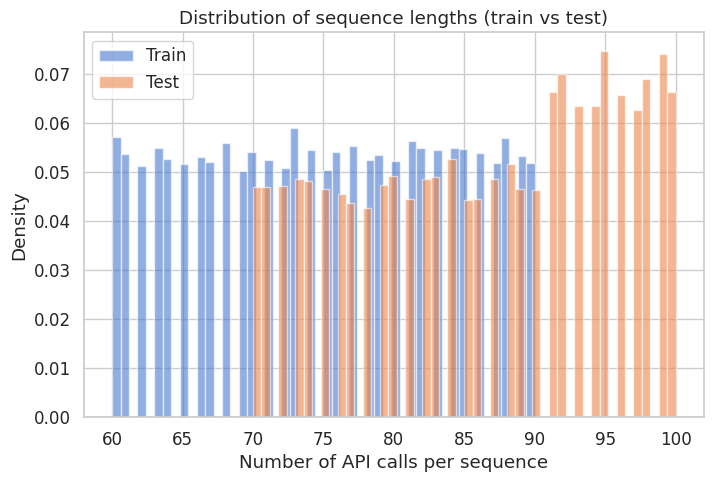

In [31]:
# --- Compare distributions visually ---
plt.figure(figsize=(8, 5))
plt.hist(df_train['seq_length'], bins=50, alpha=0.6, label='Train', density=True)
plt.hist(df_test['seq_length'], bins=50, alpha=0.6, label='Test', density=True)
plt.xlabel("Number of API calls per sequence")
plt.ylabel("Density")
plt.title("Distribution of sequence lengths (train vs test)")
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"distribution_sequence_lengths_train_test", save_dir)

plt.show()

#### Q: Do you have the same number of API calls per sequence? If not, is the distribution of API calls per sequence the same for training and test sets?

TODO: check

No, the sequences **do not all have the same length** in either the training or test sets.

- **Training set**: sequence lengths range from 60 to 90 API calls (mean ≈ 75).
- **Test set**: sequence lengths range from 70 to 100 API calls (mean ≈ 86).

The **distribution of sequence lengths is also different** between training and test sets: test sequences tend to be slightly longer on average, and the spread is shifted toward higher values. This could affect models that are sensitive to sequence length.

#### Q: Can a FFNN handle a variable number of elements? If not, why?

No, a feedforward neural network (FFNN) **cannot directly handle a variable number** of elements per input.

- FFNNs require a **fixed-size input vector**, because each input neuron corresponds to a specific feature, and the weight matrix has a fixed shape.
- If the number of elements (features) changes between samples, the network **cannot align inputs with the learned weights**, so it won't work properly.

That's why preprocessing steps like **padding sequences**, **truncating**, **or using frequency-based features** are necessary to produce a fixed-size input for FFNNs.

### Fixed-Size Sequences

#### Q: How to estimate a fixed-size candidate? Which partition do you use to estimate it?

To estimate a fixed-size input for an FFNN, it's possible to choose a representative sequence length from the training set only, since the model should not use information from the test set.

Common strategies include:
1. **Maximum length**: ensures all training sequences fit, but can be too large and waste memory.
2. **Median length**: gives a typical sequence size, but some longer sequences will need truncation.
3. **75th percentile length**: a compromise that covers most sequences without being overly large.

In [32]:
# Compute sequence lengths in training set
seq_lengths = df_train['api_call_sequence'].apply(len)

# Option 1: maximum length
max_len = seq_lengths.max()
print(f"Max length: {max_len}")

# Option 2: median
median_len = int(seq_lengths.median())
print(f"Median length: {median_len}")

# Option 3: 75th percentile
p75_len = int(np.percentile(seq_lengths, 75))
print(f"75th percentile length: {p75_len}")

Max length: 90
Median length: 75
75th percentile length: 83


#### Q: Given the estimate, what technique could you use to obtain the same number of API calls per sequence?

To obtain the same number of API calls per sequence, the main strategies are:

1. **Padding**: Add "dummy" or special tokens to sequences **shorter than the fixed length** so they reach the target size.
2. **Truncation**: **Cut sequences longer than the fixed length** to fit the target size.

By combining padding and truncation based on the estimated fixed length, you can ensure that **all sequences have the same number of elements**, which is required for an FFNN.

In [33]:
def pad_truncate_sequence(seq, fixed_len, pad_value=0):
    """
    Convert a variable-length sequence into a fixed-length sequence.

    Args:
        seq (list): original sequence (list of API calls)
        fixed_len (int): target length L
        pad_value: value to use for padding (0 is common for integers)

    Returns:
        list of length fixed_len
    """
    if len(seq) < fixed_len:
        # Pad at the end
        seq_padded = seq + [pad_value] * (fixed_len - len(seq))
    else:
        # Truncate at the end
        seq_padded = seq[:fixed_len]
    return seq_padded

In [34]:
# --- Perform padding or truncating on the training data ---

L = p75_len # chosen fixed size

# Apply the padding or truncating to all the dataframe
df_train['seq_fixed'] = df_train['api_call_sequence'].apply(lambda x: pad_truncate_sequence(x, L))

In [35]:
# --- Inspect the train set (e.g. the first row) ---

print("First row of the train set before padding:")
print(df_train['api_call_sequence'].iloc[0])
print(f"Lenght of the sequence: {len(df_train['api_call_sequence'].iloc[0])}") # should be less than L

print("\nFirst row of the train set after padding:")
print(df_train['seq_fixed'].iloc[0])
print(f"Lenght of the sequence: {len(df_train['seq_fixed'].iloc[0])}") # should be exactly L

First row of the train set before padding:
['LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'GetTimeZoneInformation', 'LoadStringW', 'RegOpenKeyExW', 'RegQueryValueExW', 'RegCloseKey', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrGetDllHandle', 'LdrGetProcedureAddress', 'SetErrorMode', 'LdrLoadDll', 'SetErrorMode', 'LdrLoadDll', 'SetErrorMode', 'GetSystemMetrics', 'FindResourceExW', 'OleInitialize', 'FindResourceExW', 'LoadResource', 'FindResourceExW', 'LoadResource', 'NtClose', 'NtAllocateVirtualMemory', 'GetSystemMetrics', 'NtAllocateVirtualMemory', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LookupAccountSidW', 'LdrGetProcedureAddress', 'LookupAccountSidW', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrLoad

#### Q: If at test time you have more API calls than the fixed-size, what do you do with the exceeding API calls?

At test time, if a sequence has **more API calls than the fixed size**, the exceeding API calls should be **truncated** to fit the fixed length. **Sequences shorter** than the fixed size are **padded** with dummy tokens.

We have decided to perform the same pad or truncate action on the test set, so that all sequences have a consistent length compatible with the FFNN.

In [36]:
# To ensure consistency, we apply the padding or truncating to also on the test df
df_test['seq_fixed'] = df_test['api_call_sequence'].apply(lambda x: pad_truncate_sequence(x, L))

In [37]:
df_train

,api_call_sequence,is_malware,seq_length,seq_fixed
0,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL...",1,73,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL..."
1,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1,88,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr..."
2,"[FindResourceExW, LoadResource, FindResourceEx...",1,79,"[FindResourceExW, LoadResource, FindResourceEx..."
3,"[FindResourceExW, LoadResource, FindResourceEx...",1,71,"[FindResourceExW, LoadResource, FindResourceEx..."
4,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad...",1,63,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad..."
...,...,...,...,...
16320,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro...",1,64,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro..."
16321,"[NtClose, LdrGetProcedureAddress, CryptCreateH...",1,78,"[NtClose, LdrGetProcedureAddress, CryptCreateH..."
16322,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,84,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG..."
16323,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,62,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG..."


In [38]:
df_test

,api_call_sequence,is_malware,seq_length,seq_fixed
0,"[NtQueryValueKey, NtClose, NtOpenKey, NtQueryV...",1,98,"[NtQueryValueKey, NtClose, NtOpenKey, NtQueryV..."
1,"[LdrGetProcedureAddress, NtClose, NtOpenKey, N...",1,98,"[LdrGetProcedureAddress, NtClose, NtOpenKey, N..."
2,"[NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe...",1,99,"[NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe..."
3,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1,85,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr..."
4,"[NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr...",1,80,"[NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr..."
...,...,...,...,...
6500,"[SetErrorMode, NtOpenFile, NtClose, SHGetFolde...",0,75,"[SetErrorMode, NtOpenFile, NtClose, SHGetFolde..."
6501,"[NtProtectVirtualMemory, RegOpenKeyExW, RegQue...",1,83,"[NtProtectVirtualMemory, RegOpenKeyExW, RegQue..."
6502,"[RegOpenKeyExW, RegQueryValueExW, RegCloseKey,...",1,70,"[RegOpenKeyExW, RegQueryValueExW, RegCloseKey,..."
6503,"[NtQueryValueKey, NtClose, RegOpenKeyExA, RegQ...",1,96,"[NtQueryValueKey, NtClose, RegOpenKeyExA, RegQ..."


### Handling Categorical Features

In [39]:
# --- Combine sequences to build a unified vocabulary ---

# Assuming df_train['seq_fixed'] and df_test['seq_fixed'] are your fixed-size sequences
all_sequences = pd.concat([df_train['seq_fixed'], df_test['seq_fixed']], axis=0)

# Flatten all sequences into a single list of API calls
all_api_calls = [api for seq in all_sequences for api in seq]

In [40]:
# --- Build vocabulary with padding handling ---

# TODO: check description
# Handle the padding value (0) - ensure it's treated as a special token
# We'll add a placeholder for padding in the vocabulary if it's not already there.
# Since we used 0 for padding, we need to adjust the mapping.
# Let's map padding to index 0 and start API call indices from 1.

# Filter strings only (exclude padding integers) and sort
unique_api_calls = sorted(list(set(api for api in all_api_calls if isinstance(api, str))))

# Check if padding (0) exists in original sequences
if any(api == 0 for api in all_api_calls) and 0 not in unique_api_calls:
    unique_api_calls.insert(0, 0) # Keep padding index at 0

# Map API call -> sequential ID
api_to_id = {api: i for i, api in enumerate(unique_api_calls)}

# Map sequential ID -> API call (for verification/debugging)
id_to_api = {i: api for api, i in api_to_id.items()}

print(f"Number of unique API calls (including padding): {len(api_to_id)}")
print("\nExample mapping (API -> ID):", list(api_to_id.items())[:5])
print("\nExample mapping (ID -> API):", list(id_to_api.items())[:5])

Number of unique API calls (including padding): 262

Example mapping (API -> ID): [(0, 0), ('CertOpenStore', 1), ('CertOpenSystemStoreW', 2), ('CoCreateInstance', 3), ('CoCreateInstanceEx', 4)]

Example mapping (ID -> API): [(0, 0), (1, 'CertOpenStore'), (2, 'CertOpenSystemStoreW'), (3, 'CoCreateInstance'), (4, 'CoCreateInstanceEx')]


#### Sequential Identifiers Approach

In [41]:
def sequence_to_ids(seq, mapping, unknown_token=None):
    """
    Convert a sequence of API calls to their corresponding IDs.
    If an API is not in mapping, use 'unknown_token' if provided.
    """
    return [mapping.get(api, unknown_token) for api in seq]

In [42]:
# --- Convert sequences to sequential IDs ---

# Apply conversion to train and test sets
df_train['seq_sequential_ids'] = df_train['seq_fixed'].apply(lambda seq: sequence_to_ids(seq, api_to_id))
df_test['seq_sequential_ids'] = df_test['seq_fixed'].apply(lambda seq: sequence_to_ids(seq, api_to_id))

# Quick check
print("\nSequential IDs - first row of train set:")
print(df_train['seq_sequential_ids'].iloc[0])
print("Length of the sequence:", len(df_train['seq_sequential_ids'].iloc[0]))

print("\nSequential IDs - first row of test set:")
print(df_test['seq_sequential_ids'].iloc[0])
print("Length of the sequence:", len(df_test['seq_sequential_ids'].iloc[0]))

# TODO: check comment
# Ready to feed into a simple FFNN (can one-hot encode IDs if needed)


Sequential IDs - first row of train set:
[117, 118, 119, 118, 117, 118, 86, 123, 202, 206, 189, 117, 118, 117, 118, 220, 119, 220, 119, 220, 81, 46, 180, 46, 121, 46, 121, 134, 133, 81, 133, 119, 118, 119, 118, 119, 118, 119, 118, 119, 118, 124, 118, 124, 119, 118, 119, 118, 119, 118, 117, 46, 121, 46, 121, 39, 81, 46, 121, 81, 39, 117, 46, 121, 46, 121, 46, 121, 117, 118, 123, 117, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length of the sequence: 83

Sequential IDs - first row of test set:
[165, 134, 153, 165, 134, 160, 122, 133, 122, 117, 118, 117, 118, 117, 122, 118, 81, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 46, 121, 118, 46, 121, 46, 121, 133, 81, 134, 81, 133, 119, 118, 117, 46, 121, 46, 121, 39, 81, 46, 121, 81, 39, 117, 46, 121, 46, 121, 46, 121, 117, 118, 122, 117, 118, 117, 118, 81]
Length of the sequence: 83


In [46]:
df_train

,api_call_sequence,is_malware,seq_length,seq_fixed,seq_sequential_ids
0,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL...",1,73,"[LdrGetDllHandle, LdrGetProcedureAddress, LdrL...","[117, 118, 119, 118, 117, 118, 86, 123, 202, 2..."
1,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1,88,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...","[133, 119, 118, 82, 80, 137, 82, 153, 154, 164..."
2,"[FindResourceExW, LoadResource, FindResourceEx...",1,79,"[FindResourceExW, LoadResource, FindResourceEx...","[46, 121, 46, 121, 46, 121, 46, 121, 46, 121, ..."
3,"[FindResourceExW, LoadResource, FindResourceEx...",1,71,"[FindResourceExW, LoadResource, FindResourceEx...","[46, 121, 46, 121, 46, 121, 46, 121, 46, 121, ..."
4,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad...",1,63,"[LdrGetProcedureAddress, SetErrorMode, LdrLoad...","[118, 220, 119, 220, 81, 46, 121, 46, 121, 46,..."
...,...,...,...,...,...
16320,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro...",1,64,"[LdrGetProcedureAddress, LdrLoadDll, LdrGetPro...","[118, 119, 118, 119, 118, 119, 118, 119, 118, ..."
16321,"[NtClose, LdrGetProcedureAddress, CryptCreateH...",1,78,"[NtClose, LdrGetProcedureAddress, CryptCreateH...","[134, 118, 24, 118, 30, 118, 135, 66, 222, 167..."
16322,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,84,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...","[118, 117, 118, 81, 217, 119, 118, 46, 121, 46..."
16323,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...",1,62,"[LdrGetProcedureAddress, LdrGetDllHandle, LdrG...","[118, 117, 118, 117, 118, 117, 118, 117, 118, ..."


In [47]:
df_test

,api_call_sequence,is_malware,seq_length,seq_fixed,seq_sequential_ids
0,"[NtQueryValueKey, NtClose, NtOpenKey, NtQueryV...",1,98,"[NtQueryValueKey, NtClose, NtOpenKey, NtQueryV...","[165, 134, 153, 165, 134, 160, 122, 133, 122, ..."
1,"[LdrGetProcedureAddress, NtClose, NtOpenKey, N...",1,98,"[LdrGetProcedureAddress, NtClose, NtOpenKey, N...","[118, 134, 153, 165, 134, 153, 165, 134, 119, ..."
2,"[NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe...",1,99,"[NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe...","[153, 165, 134, 153, 165, 134, 117, 118, 117, ..."
3,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...",1,85,"[NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...","[133, 119, 118, 119, 118, 82, 201, 205, 189, 1..."
4,"[NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr...",1,80,"[NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr...","[153, 165, 134, 118, 24, 118, 30, 118, 135, 66..."
...,...,...,...,...,...
6500,"[SetErrorMode, NtOpenFile, NtClose, SHGetFolde...",0,75,"[SetErrorMode, NtOpenFile, NtClose, SHGetFolde...","[220, 152, 134, 215, 220, 63, 220, 152, 134, 1..."
6501,"[NtProtectVirtualMemory, RegOpenKeyExW, RegQue...",1,83,"[NtProtectVirtualMemory, RegOpenKeyExW, RegQue...","[159, 202, 206, 189, 140, 133, 159, 133, 147, ..."
6502,"[RegOpenKeyExW, RegQueryValueExW, RegCloseKey,...",1,70,"[RegOpenKeyExW, RegQueryValueExW, RegCloseKey,...","[202, 206, 189, 202, 206, 189, 80, 117, 118, 2..."
6503,"[NtQueryValueKey, NtClose, RegOpenKeyExA, RegQ...",1,96,"[NtQueryValueKey, NtClose, RegOpenKeyExA, RegQ...","[165, 134, 201, 205, 189, 154, 165, 134, 119, ..."


#### Learnable Embeddings Approach

In [43]:
# TODO: add comment to explain that this process is done in the first layer of the model

### FFNN Training

In [50]:
class MalwareFFNN(nn.Module):
    def __init__(self, seq_len, vocab_size=None, hidden_dims=[128,64,32],
                 embedding_dim=16, use_embedding=True):
        """
        Flexible FFNN for malware classification.

        Parameters:
        - seq_len: length of each API call sequence
        - vocab_size: number of unique API calls (required if use_embedding=True)
        - hidden_dims: list of hidden layer sizes
        - embedding_dim: size of embedding vectors (only used if use_embedding=True)
        - use_embedding: whether to use an embedding layer (True) or raw sequential IDs / one-hot (False)
        """
        super(MalwareFFNN, self).__init__()
        self.use_embedding = use_embedding

        if self.use_embedding:
            if vocab_size is None:
                raise ValueError("vocab_size must be provided if use_embedding=True")

            # Embedding layer for sequential IDs
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=embedding_dim,
                                          padding_idx=0)
            input_dim = seq_len * embedding_dim
        else:
            # Input will be one-hot encoded or numeric vector
            input_dim = seq_len # assumes IDs are already numeric (one-hot flattening can be done outside)

        # Build hidden layers
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = h_dim
        self.ffnn = nn.Sequential(*layers)

        # Output layer: binary classification
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        if self.use_embedding:
            # x: [batch_size, seq_len] of IDs
            x = self.embedding(x)     # [batch_size, seq_len, embedding_dim]
            x = x.view(x.size(0), -1) # flatten: [batch_size, seq_len*embedding_dim]
        else:
            # x: [batch_size, seq_len] or [batch_size, seq_len*vocab_size] if one-hot flattened
            x = x.float()

        x = self.ffnn(x)
        out = self.output_layer(x)    # [batch_size, 1]
        return out

In [51]:
# --- Training function with early stopping ---

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, min_delta=None, patience=None):

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        if (epoch+1) % 5 == 0 or epoch == 0 or epoch == epochs:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [52]:
def evaluate_model(model, X_tensor, y_true, model_name: str = "Unnamed model"):
    """
    Evaluate a trained model on a given dataset and return the classification report.

    Handles missing predicted classes gracefully (zero_division=0) and reports
    which classes were not predicted, along with the model/config name.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

    # Convert y_true to numpy if it's a tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()

    # Identify missing classes (not predicted at all)
    missing_classes = set(np.unique(y_true)) - set(np.unique(y_pred))
    if missing_classes:
        # Convert NumPy types to plain ints for readability
        missing_classes = [int(x) for x in sorted(missing_classes)]
        print(f"Warning: {model_name} made no predictions for classes: {missing_classes}")

    # Generate classification report without raising warnings
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)

    return report

#### Training with Sequential Identifiers Approach

In [58]:
# --- Create a validation set ---

# Convert sequences to a numpy array (shape: [samples, seq_len])
X_train = np.array(df_train['seq_sequential_ids'].tolist())
X_test = np.array(df_test['seq_sequential_ids'].tolist())

# Labels
y_train = y.values
y_test = y_test.values

# Split train into train + val
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train set:", X_train_split.shape, y_train_split.shape)
print("Validation set:", X_val.shape, y_val.shape)

Train set: (13060, 83) (13060,)
Validation set: (3265, 83) (3265,)


In [59]:
# --- Prepare PyTorch datasets and loaders ---

# Convert to tensors
X_train_tensor = torch.tensor(X_train_split, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create datasets and loaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [60]:
# --- Initialize model, loss, optimizer ---

seq_len = X_train.shape[1]
hidden_dims = [128, 64, 32] # 3-layer FFNN

# Initialize the early stopping parameters
min_delta = 0.00001
patience = 20

model_seq = MalwareFFNN(seq_len=seq_len, hidden_dims=hidden_dims, use_embedding=False)
criterion = nn.BCEWithLogitsLoss() # combines sigmoid + BCE
optimizer = optim.AdamW(model_seq.parameters(), lr=0.0005)
epochs = 100

# Train the model
model, train_loss, val_loss = train_model(
    model_seq,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)

Epoch 1/100 - Train Loss: 0.3344, Val Loss: 0.1767
Epoch 5/100 - Train Loss: 0.1838, Val Loss: 0.1699
Epoch 10/100 - Train Loss: 0.1759, Val Loss: 0.1660
Epoch 15/100 - Train Loss: 0.1709, Val Loss: 0.1567
Epoch 20/100 - Train Loss: 0.1739, Val Loss: 0.1579
Epoch 25/100 - Train Loss: 0.1760, Val Loss: 0.1693
Epoch 30/100 - Train Loss: 0.1772, Val Loss: 0.1671
Early stopping at epoch 35 (best val loss: 0.156672)


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/results/images/task2_plots/loss_curves_model_seq_id_ffnn.png


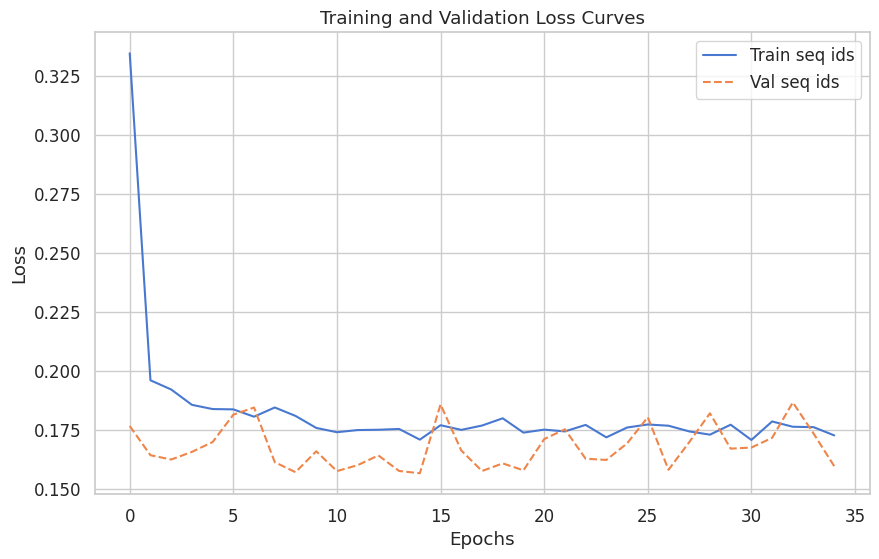

In [61]:
# --- Plot loss curves ---

plt.figure(figsize=(10,6))
plt.plot(train_loss, label=f'Train seq ids')
plt.plot(val_loss, '--', label=f'Val seq ids')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"loss_curves_model_seq_id_ffnn", save_dir)

plt.show()

In [62]:
# --- Evaluate validation set and print classification reports ---

print("\nValidation classification reports:")
report = evaluate_model(model_seq, X_val_tensor, y_val)
print(report)


Validation classification reports:
              precision    recall  f1-score   support

           0     0.0374    1.0000    0.0720       122
           1     0.0000    0.0000    0.0000      3143

    accuracy                         0.0374      3265
   macro avg     0.0187    0.5000    0.0360      3265
weighted avg     0.0014    0.0374    0.0027      3265



#### Training with Learnable Embeddings Approach

In [65]:
# --- Initialize model, loss, optimizer ---

seq_len = X_train.shape[1]
vocab_size = len(api_to_id)  # Include padding token
embedding_dim = 16           # Hyperparameter to tune (e.g., 8, 16, 32)
hidden_dims = [128, 64, 32]  # Same as sequential IDs version

# Initialize early stopping parameters
min_delta = 0.00001
patience = 20

# Initialize model with embedding layer
model_emb = MalwareFFNN(
    seq_len=seq_len,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dims=hidden_dims,
    use_embedding=True
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_emb.parameters(), lr=0.0005)
epochs = 100

# Train the model
model_emb, train_loss_emb, val_loss_emb = train_model(
    model_emb,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)

Epoch 1/100 - Train Loss: 0.2030, Val Loss: 0.1458
Epoch 5/100 - Train Loss: 0.1043, Val Loss: 0.1491
Epoch 10/100 - Train Loss: 0.1028, Val Loss: 0.1407
Epoch 15/100 - Train Loss: 0.0851, Val Loss: 0.1391
Epoch 20/100 - Train Loss: 0.0845, Val Loss: 0.1526
Epoch 25/100 - Train Loss: 0.0871, Val Loss: 0.1505
Epoch 30/100 - Train Loss: 0.0829, Val Loss: 0.1462
Early stopping at epoch 32 (best val loss: 0.134981)


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory2/results/images/task2_plots/loss_curves_model_embedding_ffnn.png


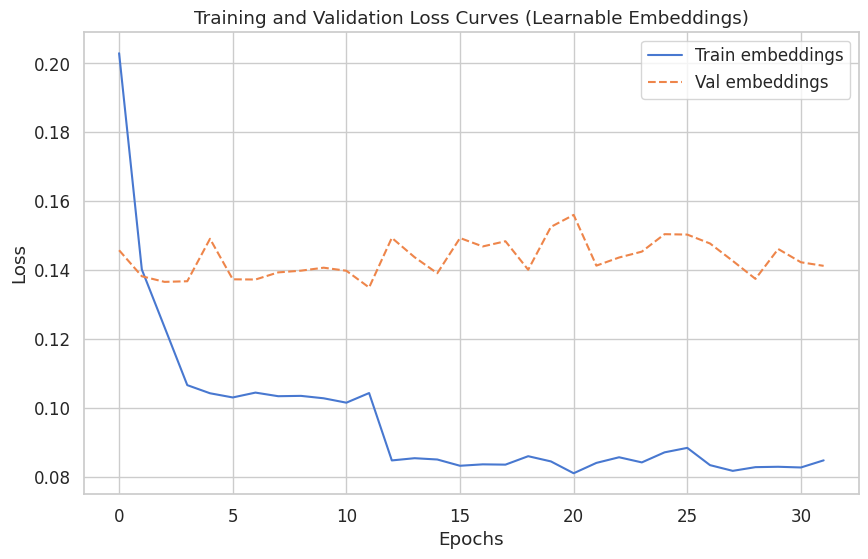

In [66]:
# --- Plot loss curves ---

plt.figure(figsize=(10,6))
plt.plot(train_loss_emb, label='Train embeddings')
plt.plot(val_loss_emb, '--', label='Val embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves (Learnable Embeddings)')
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"loss_curves_model_embedding_ffnn", save_dir)

plt.show()

In [67]:
# --- Evaluate validation set and print classification reports ---

print("\nValidation classification reports:")
report_emb = evaluate_model(model_emb, X_val_tensor, y_val)
print(report_emb)


Validation classification reports:
              precision    recall  f1-score   support

           0     0.0374    1.0000    0.0720       122
           1     0.0000    0.0000    0.0000      3143

    accuracy                         0.0374      3265
   macro avg     0.0187    0.5000    0.0360      3265
weighted avg     0.0014    0.0374    0.0027      3265



#### Q: Use a FFNN in both cases. Report how you selected the hyperparameters of your final model, and justify your choices.

#### Q: Can you obtain the same results for sequential identifiers and learnable embeddings? If not, why?

## Task 3 - Recursive Neural Network (RNN)

text

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

### Sequence Modeling with RNNs

#### Q: With RNNs, do you still have to pad your data? If yes, how?

#### Q: Do you have to truncate the testing sequences? Justify your answer.

#### Q: Is the RNN padding more memory efficient compared to the FFNN’s one? Why?

#### Q: Start with a simple one-directional RNN. Is your network as fast as the FFNN? If not, why?

### Network Variations

#### Q: Is the RNN training as stable as the FFNN's one?

#### Q: How does your model's performance compare to the simple frequency baseline?

## Task 4 - Graph Neural Network (GNN)

text

In [ ]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### Modeling API Sequences as Graphs

#### Q: Do you still have to pad your data? If yes, how?

#### Q: Do you have to truncate the testing sequences? Justify your answer.

#### Q: What is the advantage of modeling your problem with a GNN compared to an RNN? What do you lose?

### GNN Variations

#### Q: How does each model perform compared to the previous architectures? Can you beat the baseline?